### Importing Libraries

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Custom Seaborn Style

---

In [2]:
sns.set_theme('paper')
sns.set_style('ticks')

### Adding `utils` to `PYTHONPATH`

---

In [3]:
sys.path.append(os.path.abspath("../utils"))

### Reading Parquet File

---

In [4]:
# Importing load_parquet function from read_data module
from read_data import load_parquet
cars = load_parquet('clean_data', 'clean_data.parquet')
cars.head()

,km_driven,fuel_type,transmission,owner,price,engine_capacity,year,brand,model
0,88760,Petrol,Manual,1st owner,219000,998,2012,Maruti,Wagon R 1.0
1,17920,Petrol,Manual,1st owner,266000,796,2016,Maruti,Alto 800
2,9940,Petrol,Manual,1st owner,496000,1373,2014,Maruti,Ertiga
3,67340,Petrol,Manual,2nd owner,355000,1199,2016,Tata,Tiago
4,30390,Petrol,Manual,1st owner,530000,998,2023,Maruti,New Wagon-R


### Handling `year` Column

---

In [5]:
# Frequency Distribution of "year" column
cars['year'].value_counts()

year
2022    310
2021    305
2018    286
2017    274
2019    263
2016    243
2020    234
2023    194
2015    188
2014    168
2013    131
2024     76
2012     65
2011     49
2010     36
2025      1
2007      1
Name: count, dtype: int64

In [6]:
# As we can see, 2007 and 2025 are very rare in our data occuring only 1 time as compared to other values
# So it's better to remove them, because model can't learn any pattern of year 2007 or 2025 with just 1 value
# And it can also cause model to overfit instead of learning meaningful patterns
cars = cars[(cars['year']!=2007) & (cars['year']!=2025)]

### Handling `transmission` Column

---

In [7]:
# Frequency Distribution of "transmission" column
cars['transmission'].value_counts()

transmission
Manual       1910
Automatic     912
Name: count, dtype: int64

### Handling `owner` Column

---

In [8]:
# Frequency Distribution of "owner" column
cars['owner'].value_counts()

owner
1st owner    2041
2nd owner     639
3rd owner     114
4th owner      25
5th owner       2
6th owner       1
Name: count, dtype: int64

In [9]:
# As we can see, categories in "owner" column like "5th owner" and "6th owner" are very rare as compared to other values
# So we will remove "5th owner" and "6th owner" from "owner" column
# And since "4th owner" is also significantly less occuring than other categories, we will rename it to "Others"
# This way we will reduce overfitting and help model learn and generalize better
cars = cars[cars['owner'].isin(['1st owner','2nd owner','3rd owner','4th owner'])]

In [10]:
# Because we have converted "owner" column into category datatype, we also have to remove unused categories manually
cars['owner'] = cars['owner'].cat.remove_unused_categories()

In [11]:
# Renaming "4th owner" as "Others"
cars['owner'] = cars['owner'].cat.rename_categories({'4th owner':'Others'})

In [12]:
# Frequency Distribution of "owner" column after transformation
cars['owner'].value_counts()

owner
1st owner    2041
2nd owner     639
3rd owner     114
Others         25
Name: count, dtype: int64

### Handling `fuel_type` Column

---

In [13]:
# Frequency Distribution of "fuel_type" column
cars['fuel_type'].value_counts()

fuel_type
Petrol      2074
Diesel       614
CNG          114
Electric      15
Hybrid         2
Name: count, dtype: int64

In [14]:
# Average price based on "fuel_type" column
# Hybrid cars are very rare in our data but their average price is very high as compared to other categories
# It makes Hybrid cars rare and dominant category which can cause overfitting and create problem in generalization of model
cars.groupby('fuel_type', observed=True)['price'].mean().apply(lambda x: round(x)).sort_values()

fuel_type
CNG          505184
Petrol       675871
Electric     774800
Diesel      1173664
Hybrid      3995000
Name: price, dtype: int64

In [15]:
# So we will remove Hybrid cars from the data
cars = cars[~cars['fuel_type'].isin(['Hybrid'])]

In [16]:
# Because we have converted "fuel_type" column into category datatype, we also have to remove unused categories manually
cars['fuel_type'] = cars['fuel_type'].cat.remove_unused_categories()

In [17]:
# Frequency Distribution of "fuel_type" column after transformation
cars['fuel_type'].value_counts()

fuel_type
Petrol      2074
Diesel       614
CNG          114
Electric      15
Name: count, dtype: int64

### Handling `km_driven` Column

---

- 99th percentile of 'km_driven' column is 1,90,000 which means that 99% of the data points lie below 1,90,000.
- However, the maximum value is 7,00,000 which is significantly higher than the rest of the distribution.
- This extreme value is likely an outlier and may distort statistical analyses such as the mean or standard deviation.
- Therefore, it should be carefully examined and handled appropriately.

In [18]:
# Description of "km_driven" column
km_describe = cars.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])['km_driven'].apply(lambda x: f"{x:.2f}")
km_describe

count      2817.00
mean      57827.40
std       37997.17
min        1140.00
1%         5144.80
5%        12932.00
10%       18756.00
25%       31810.00
50%       52940.00
75%       75430.00
90%       98194.00
95%      120000.00
99%      190000.00
max      700000.00
Name: km_driven, dtype: object

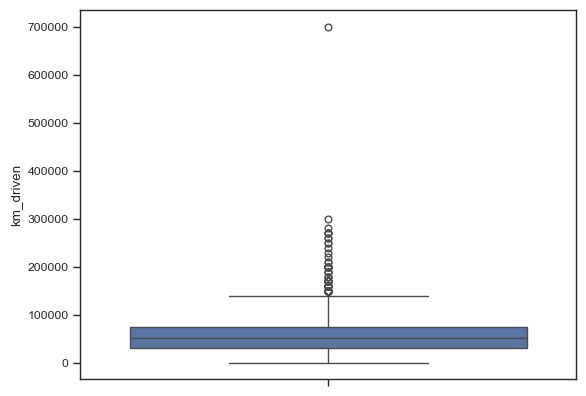

In [19]:
# Box Plot of "km_driven" column
sns.boxplot(cars['km_driven'])
plt.show()

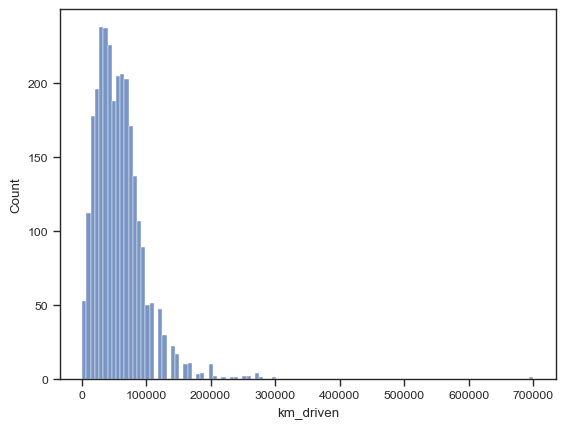

In [20]:
# Distribution of "km_driven" column
sns.histplot(cars['km_driven'])
plt.show()

- Since the distribution of 'km_driven' column is skewed, methods like Z-Score may not be reliable.
- Instead, we apply the Interquartile Range (IQR) method, which is robust to skewness and extreme values.
$$IQR = Q3 - Q1$$
where:
- $Q1$ is 25th percentile
- $Q3$ is 75th percentile

In [21]:
# First quartile or 25th percentile
q1 = cars['km_driven'].quantile(0.25)

# Third quartile or 75th percentile
q3 = cars['km_driven'].quantile(0.75)

In [22]:
# IQR = Q3 - Q1
iqr = q3 - q1

- To eliminate the most extreme outliers, we use a stricter threshold :
$$\text{Lower Limit} = Q1 - 3 \times \text{IQR}$$
$$\text{Upper Limit} = Q3 + 3 \times \text{IQR}$$
- Any value outside this range is considered an extreme outlier and is removed from the dataset.
- This way we can preserves as much data as possible, while reducing the impact of extreme values.

In [23]:
# Range of Extreme Outliers
extreme_lower_limit = q1 - 3*iqr
extreme_upper_limit = q3 + 3*iqr

In [24]:
# Detecting Extreme Outliers
cars[(cars['km_driven'] < extreme_lower_limit) | (cars['km_driven'] > extreme_upper_limit)]

,km_driven,fuel_type,transmission,owner,price,engine_capacity,year,brand,model
752,240000,Diesel,Manual,1st owner,89000,1399,2011,Ford,Figo
784,210000,Petrol,Automatic,2nd owner,517000,1497,2014,Honda,City
817,700000,Diesel,Manual,1st owner,210000,1248,2014,Fiat,Grand Punto
835,230000,Petrol,Manual,2nd owner,190000,1197,2011,Maruti,Swift Dzire
860,300000,Diesel,Manual,2nd owner,100000,1199,2013,Tata,Indica V2
878,270000,Diesel,Manual,1st owner,516000,1498,2015,Ford,Ecosport
1068,260000,Diesel,Manual,1st owner,400000,2179,2011,Mahindra,Scorpio
1229,270000,Diesel,Manual,1st owner,2381000,2755,2019,Toyota,Fortuner
1231,270000,Diesel,Manual,1st owner,450000,2494,2011,Toyota,Innova
1347,250000,Diesel,Manual,2nd owner,360000,2489,2017,Mahindra,Xylo


In [25]:
# Index of Extreme Outliers
extreme_outlier_idx = cars[(cars['km_driven'] < extreme_lower_limit) | (cars['km_driven'] > extreme_upper_limit)].index
extreme_outlier_idx

Index([ 752,  784,  817,  835,  860,  878, 1068, 1229, 1231, 1347, 1350, 1359,
       1371, 1396, 1432, 1441],
      dtype='int64')

In [26]:
# Removing Extreme Outliers
updated_cars = cars.drop(index=extreme_outlier_idx, axis=0)

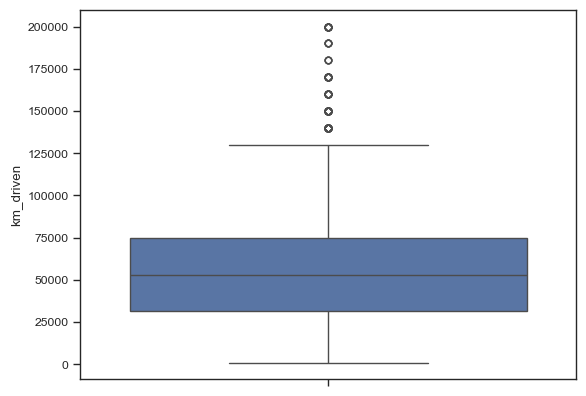

In [27]:
# Box Plot of "km_driven" column after Outlier Removal
sns.boxplot(updated_cars['km_driven'])
plt.show()

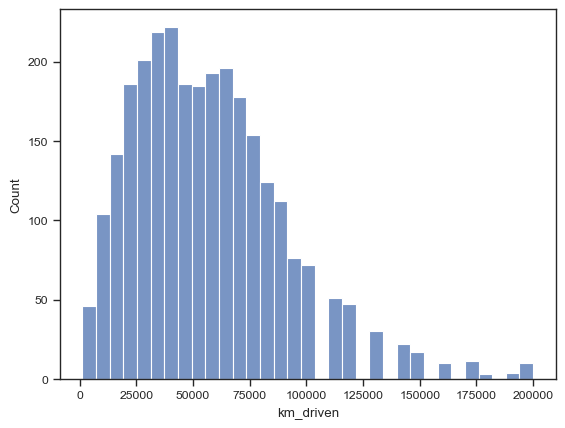

In [28]:
# Distribution of "km_driven" column after Outlier Removal
sns.histplot(updated_cars['km_driven'])
plt.show()

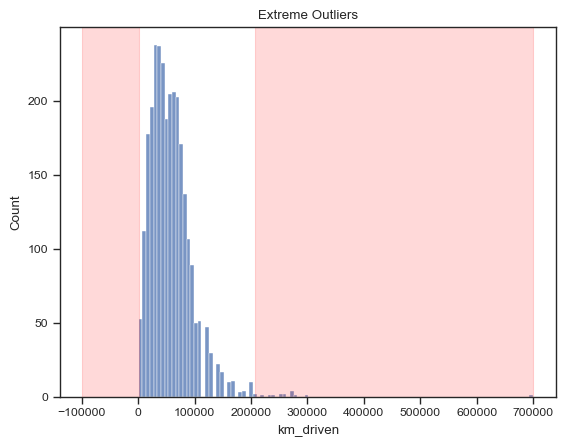

In [29]:
# Visual Representation of Outliers in the Data
sns.histplot(cars['km_driven'])
plt.axvspan(xmin=extreme_lower_limit, xmax=cars['km_driven'].min(), alpha=0.15, color='red')
plt.axvspan(xmin=extreme_upper_limit, xmax=cars['km_driven'].max(), alpha=0.15, color='red')
plt.title('Extreme Outliers')
plt.show()

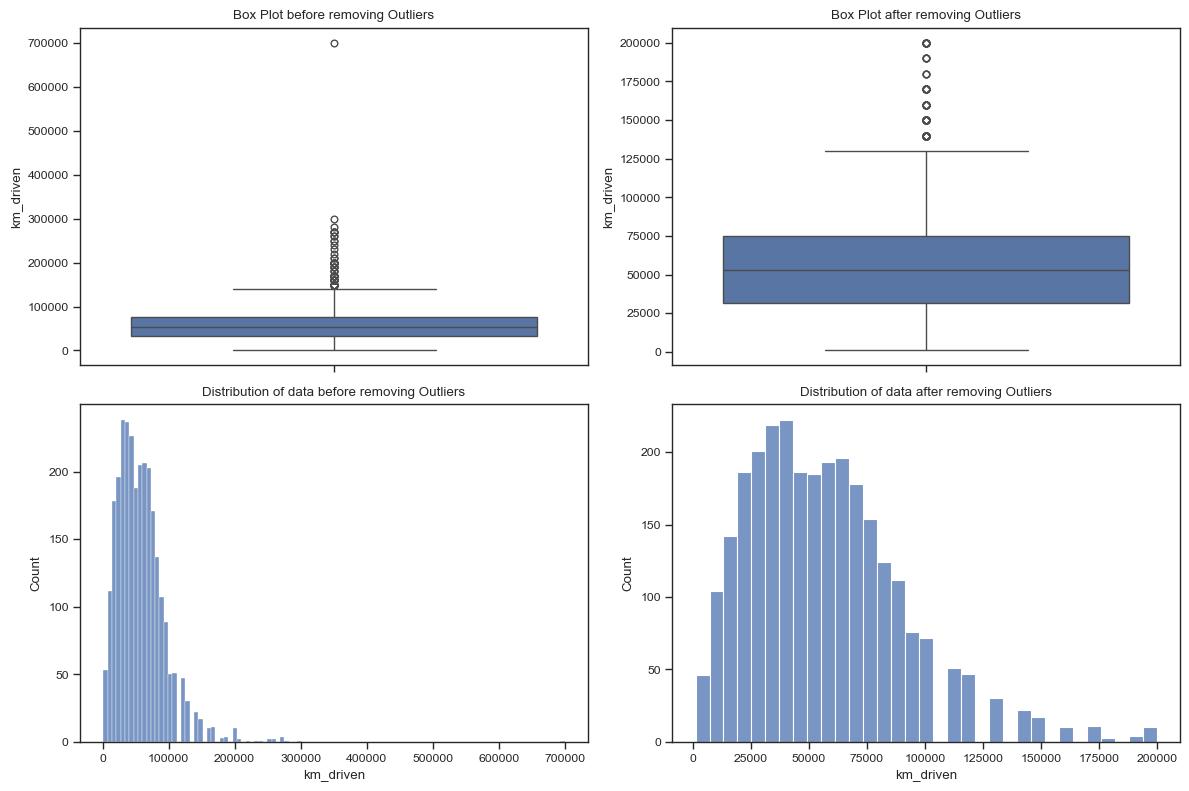

In [30]:
# Before and After of "km_driven" column
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
sns.boxplot(cars['km_driven'], ax=ax[0,0])
sns.boxplot(updated_cars['km_driven'], ax=ax[0,1])
sns.histplot(cars['km_driven'], ax=ax[1,0])
sns.histplot(updated_cars['km_driven'], ax=ax[1,1])
ax[0,0].set_title('Box Plot before removing Outliers')
ax[0,1].set_title('Box Plot after removing Outliers')
ax[1,0].set_title('Distribution of data before removing Outliers')
ax[1,1].set_title('Distribution of data after removing Outliers')
plt.tight_layout()
plt.show()

### Handling `price` Column

---

- 99th percentile of 'price' column is ₹43,75,000 which means that 99% of the data points lie below ₹43,75,000.
- However, the maximum value is ₹2,50,00,000 which is significantly higher than the rest of the distribution.
- This extreme value is likely an outlier and may distort statistical analyses such as the mean or standard deviation.
- Therefore, it should be carefully examined and handled appropriately.

In [31]:
# Description of "price" column
price_describe = updated_cars.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])['price'].apply(lambda x: f"{x:.2f}")
price_describe

count        2801.00
mean       778857.55
std        852895.11
min         57000.00
1%         148000.00
5%         225000.00
10%        279000.00
25%        395000.00
50%        575000.00
75%        869000.00
90%       1340000.00
95%       1975000.00
99%       4375000.00
max      25000000.00
Name: price, dtype: object

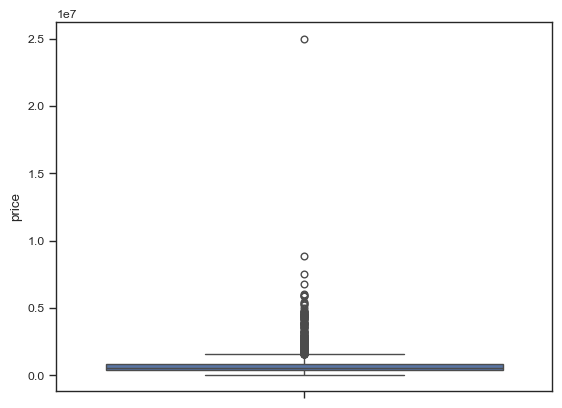

In [32]:
# Box Plot of "price" column
sns.boxplot(updated_cars['price'])
plt.show()

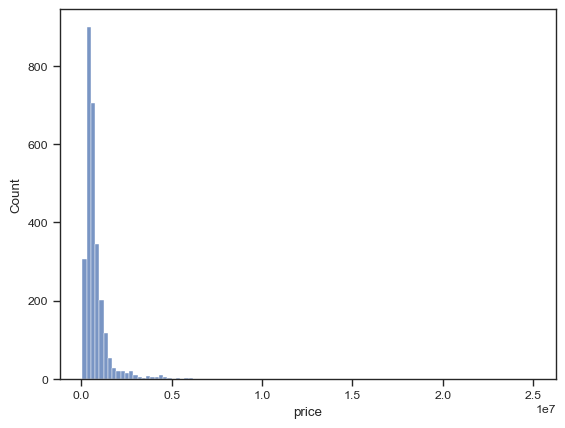

In [33]:
# Distribution of "price" column
sns.histplot(updated_cars['price'])
plt.show()

- We're working with 'price' column, which have a wide range (from ₹1,20,000 to ₹25,000,000).
- Some cars can be unusually cheap or extremely expensive.
- They are outliers and can affect our analysis or modeling.

So we're using a two-step process to handle them :

**Step 1 : Removing Suspiciously Extreme values Using Percentiles**
- Some prices are extremly high or unusually low that they could distort our model or visualizations.
- So we use percentiles to define what's extreme or what's low.
- Remove the rows where price is below 1st percentile or above 99th percentile.

**Step 2 : Removing Rest of Extreme values using IQR Method**
- Now that we've removed the most extreme values, we still have to treat values that are unusually high but not extreme.
- For that, we use the IQR method :
    - Q1 (25th percentile)
    - Q3 (75th percentile)
    - IQR = Q3 - Q1
- We then calculate :
    - Lower Limit = Q1 - 3 × IQR
    - Upper Limit = Q3 + 3 × IQR
- Instead of taking the common threshold (Q1 - 1.5 x IQR), we will use a stricter threshold (Q1 - 3 x IQR).
- By removing these unusually high but not extreme values, we eliminated values that are far different from the bulk.
- This approach help reduce the influence of most extreme values.

In [34]:
# Detecting Suspiciously Extreme Outliers using Percentiles
updated_cars[(updated_cars['price'] < float(price_describe['1%'])) | (updated_cars['price'] > float(price_describe['99%']))]

,km_driven,fuel_type,transmission,owner,price,engine_capacity,year,brand,model
333,56630,Diesel,Automatic,2nd owner,4395000,2993,2017,BMW,X5
345,10860,Petrol,Automatic,1st owner,7500000,2998,2024,BMW,M340i
357,36000,Diesel,Automatic,1st owner,4575000,1950,2020,Mercedes,Benz E Class
381,21000,Diesel,Automatic,1st owner,4500000,4367,2012,Landrover,Range Rover
382,24610,Diesel,Automatic,1st owner,4775000,4367,2012,Landrover,Range Rover
415,25300,Diesel,Automatic,1st owner,4975000,1969,2019,Volvo,S90
439,7220,Petrol,Automatic,1st owner,4600000,1991,2022,Mercedes,Benz A CLASS LIMOUSINE
479,39240,Petrol,Automatic,1st owner,5275000,1991,2022,Mercedes,Benz GLC CLASS
656,95730,Petrol,Manual,3rd owner,142000,1086,2010,Hyundai,i10
658,55000,Diesel,Manual,1st owner,128000,1405,2011,Tata,Indigo ECS


In [35]:
# Index of Suspiciously Extreme Outliers
extreme_outlier_idx = updated_cars[(updated_cars['price'] < float(price_describe['1%'])) | (updated_cars['price'] > float(price_describe['99%']))].index
extreme_outlier_idx

Index([ 333,  345,  357,  381,  382,  415,  439,  479,  656,  658,  680,  705,
        722,  729,  731,  759,  765,  775,  801,  816,  819,  847,  858,  868,
        870,  908,  912,  926,  933,  999, 1043, 1454, 1456, 1940, 2543, 2544,
       2552, 2553, 2558, 2570, 2586, 2587, 2601, 2607, 2611, 2618, 2626, 2630,
       2632, 2634, 2646, 2663, 2664, 2679, 2686, 2689],
      dtype='int64')

In [36]:
# Removing Suspiciously Extreme Outliers
updated_cars = updated_cars.drop(index=extreme_outlier_idx, axis=0)

In [37]:
# First quartile or 25th percentile
q1 = updated_cars['price'].quantile(0.25)

# Third quartile or 75th percentile
q3 = updated_cars['price'].quantile(0.75)

In [38]:
# IQR = Q3 - Q1
iqr = q3 - q1

In [39]:
# Range of Extreme Outliers
extreme_lower_limit = q1 - 3*iqr
extreme_upper_limit = q3 + 3*iqr

In [40]:
# Detecting Extreme Outliers
updated_cars[(updated_cars['price'] < extreme_lower_limit) | (updated_cars['price'] > extreme_upper_limit)]

,km_driven,fuel_type,transmission,owner,price,engine_capacity,year,brand,model
324,46330,Diesel,Automatic,1st owner,4295000,2987,2016,Mercedes,Benz GLE
325,56000,Diesel,Automatic,2nd owner,3650000,1950,2017,Mercedes,Benz E Class
331,140000,Diesel,Automatic,1st owner,2900000,1968,2015,Audi,Q7
335,46300,Diesel,Automatic,1st owner,4199000,2987,2016,Mercedes,Benz GLE
338,77590,Diesel,Automatic,1st owner,2600000,1995,2018,BMW,X1
...,...,...,...,...,...,...,...,...,...
2659,120000,Diesel,Automatic,2nd owner,2550000,1996,2021,Ford,Endeavour
2682,39100,Diesel,Automatic,2nd owner,2280000,2143,2018,Mercedes,Benz GLA Class
2690,32770,Diesel,Automatic,1st owner,3800000,2755,2022,Toyota,Fortuner
2691,36630,Petrol,Automatic,1st owner,2600000,1991,2018,Mercedes,Benz C Class


In [41]:
# Index of Extreme Outliers
extreme_outlier_idx = updated_cars[(updated_cars['price'] < extreme_lower_limit) | (updated_cars['price'] > extreme_upper_limit)].index
extreme_outlier_idx

Index([ 324,  325,  331,  335,  338,  340,  351,  353,  366,  373,  376,  396,
        400,  401,  402,  403,  409,  410,  440,  442,  445,  451,  458,  467,
        478,  480, 1373, 1406, 1443, 1448, 1460, 1464, 1503, 1923, 2542, 2545,
       2546, 2547, 2548, 2551, 2561, 2569, 2571, 2572, 2573, 2574, 2575, 2576,
       2578, 2585, 2590, 2591, 2592, 2594, 2596, 2599, 2600, 2602, 2604, 2605,
       2606, 2608, 2609, 2610, 2616, 2617, 2619, 2625, 2627, 2629, 2631, 2633,
       2635, 2636, 2640, 2641, 2643, 2647, 2648, 2659, 2682, 2690, 2691, 2757],
      dtype='int64')

In [42]:
# Removing Extreme Outliers
updated_cars = updated_cars.drop(index=extreme_outlier_idx, axis=0)

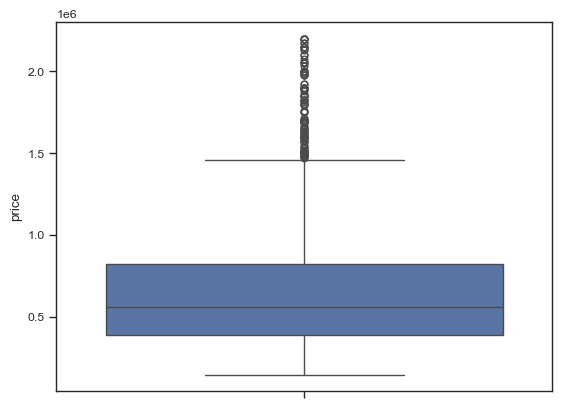

In [43]:
# Box Plot of "price" column after Outlier Removal
sns.boxplot(updated_cars['price'])
plt.show()

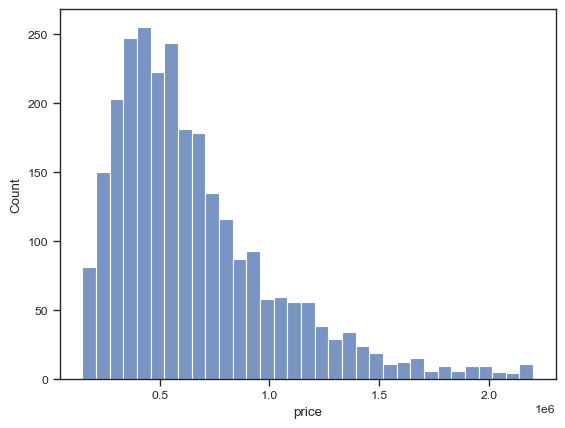

In [44]:
# Distribution of "price" column after Outlier Removal
sns.histplot(updated_cars['price'])
plt.show()

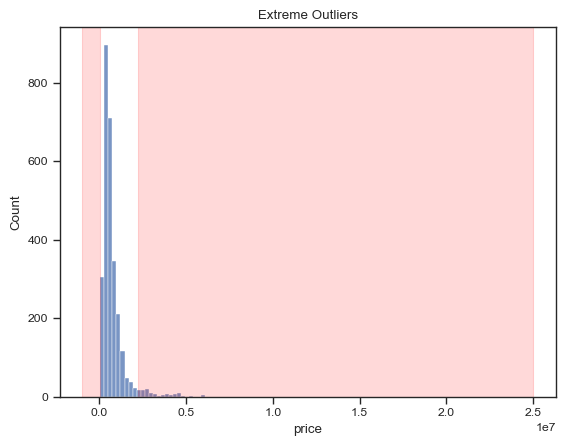

In [45]:
# Visual Representation of Outliers in the Data
sns.histplot(cars['price'])
plt.axvspan(xmin=extreme_lower_limit, xmax=cars['price'].min(), alpha=0.15, color='red')
plt.axvspan(xmin=extreme_upper_limit, xmax=cars['price'].max(), alpha=0.15, color='red')
plt.title('Extreme Outliers')
plt.show()

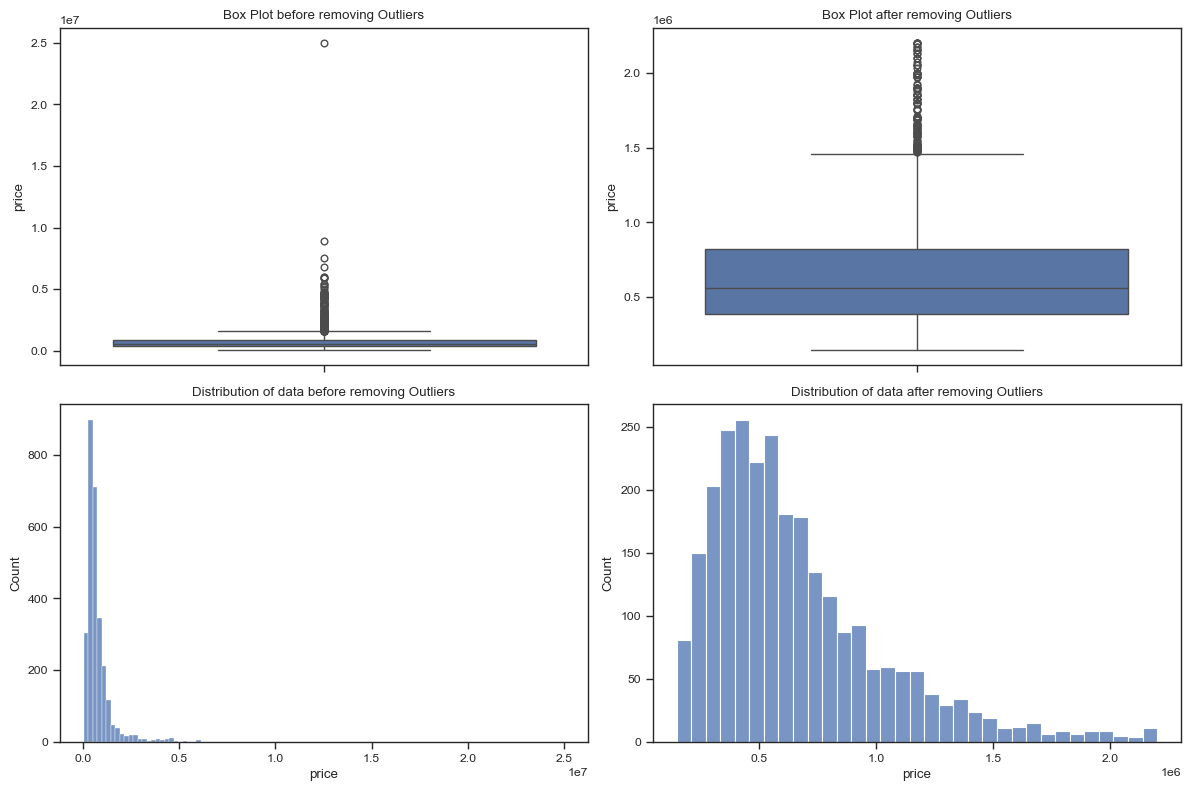

In [46]:
# Before and After of "price" column
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
sns.boxplot(cars['price'], ax=ax[0,0])
sns.boxplot(updated_cars['price'], ax=ax[0,1])
sns.histplot(cars['price'], ax=ax[1,0])
sns.histplot(updated_cars['price'], ax=ax[1,1])
ax[0,0].set_title('Box Plot before removing Outliers')
ax[0,1].set_title('Box Plot after removing Outliers')
ax[1,0].set_title('Distribution of data before removing Outliers')
ax[1,1].set_title('Distribution of data after removing Outliers')
plt.tight_layout()
plt.show()

### Handling `engine_capacity` Column

---

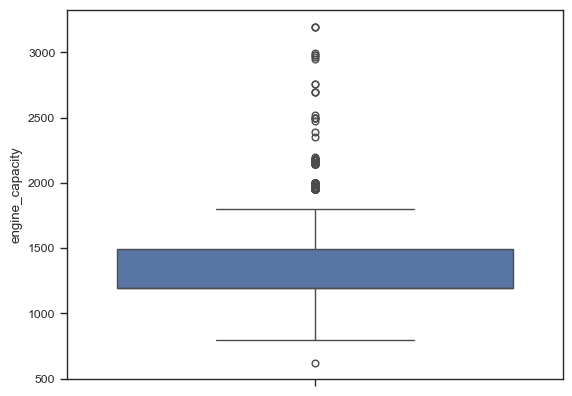

In [47]:
# Box Plot of "engine_capacity" column
sns.boxplot(updated_cars['engine_capacity'])
plt.show()

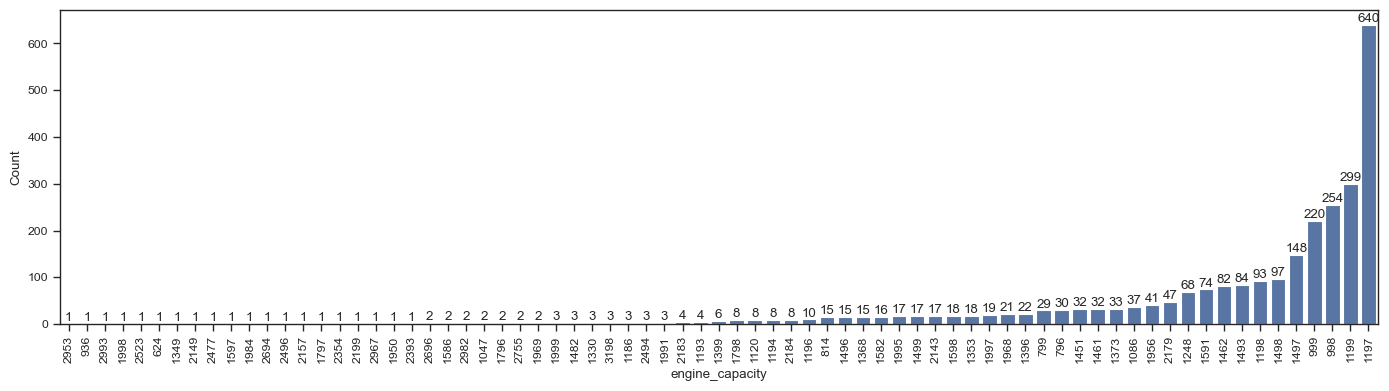

In [48]:
# Frequency Distribution of "engine_capacity" column
# As we can see, there are lots of rare categories, which may be noise and can cause overfitting
plt.figure(figsize=(14,4))
ax = sns.countplot(data=updated_cars, x='engine_capacity', order=updated_cars['engine_capacity'].value_counts().sort_values().index)
ax.bar_label(ax.containers[0])
plt.xlabel('engine_capacity')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [49]:
# Frequency Distribution of "engine_capacity" column
engine_freq = updated_cars['engine_capacity'].value_counts()
engine_freq

engine_capacity
1197    640
1199    299
998     254
999     220
1497    148
       ... 
2694      1
1950      1
2967      1
2199      1
2393      1
Name: count, Length: 73, dtype: int64

In [50]:
# Selecting "engine_capacity" having count greater than or equal to 4 as "top_engines"
top_engines = engine_freq[engine_freq >= 4].index
top_engines

Index([1197, 1199,  998,  999, 1497, 1498, 1198, 1493, 1462, 1591, 1248, 2179,
       1956, 1086, 1373, 1461, 1451,  796,  799, 1396, 1968, 1997, 1353, 1598,
       1995, 2143, 1499, 1582,  814, 1368, 1496, 1196, 1798, 1194, 1120, 2184,
       1399, 1193, 2183],
      dtype='int16', name='engine_capacity')

In [51]:
# Removing rare categories from "engine_capacity" column
updated_cars = updated_cars[updated_cars['engine_capacity'].isin(top_engines)]

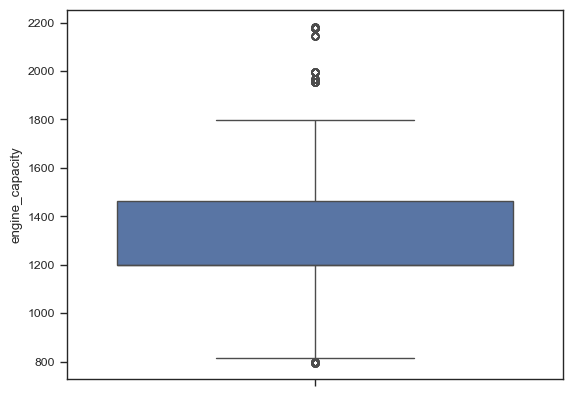

In [52]:
# Box Plot of "engine_capacity" column after transformation
sns.boxplot(updated_cars['engine_capacity'])
plt.show()

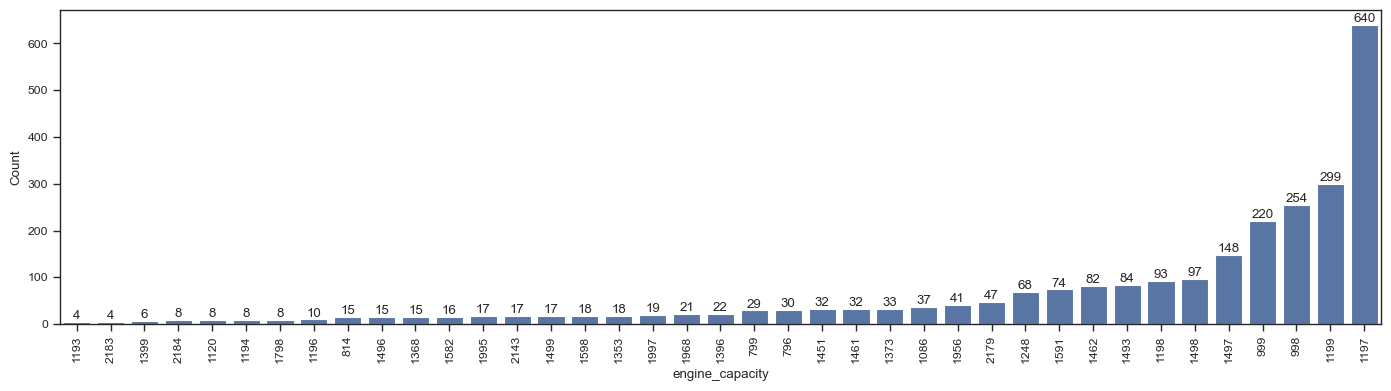

In [53]:
# Frequency Distribution of "engine_capacity" column after transformation
plt.figure(figsize=(14,4))
ax = sns.countplot(data=updated_cars, x='engine_capacity', order=updated_cars['engine_capacity'].value_counts().sort_values().index)
ax.bar_label(ax.containers[0])
plt.xlabel('engine_capacity')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Handling `brand` Column

---

In [54]:
# Frequency Distribution of "brand" column
# As we can see, there are some brands with very few cars as compared to other brands (rare categories)
# Also there are some car brands that are removed from the data but the brand name still exist in the column
# This is because we have converted the "brand" column into category datatype, so we have to remove these categories manually
brand_freq = updated_cars['brand'].value_counts()
brand_freq

brand
Maruti        689
Hyundai       540
Tata          280
Honda         211
Renault       191
Mahindra      130
KIA           110
Ford           88
Volkswagen     73
Skoda          61
MG             54
Toyota         41
Nissan         30
Datsun         21
Jeep           21
Audi           19
Mercedes       17
BMW            16
Fiat            7
Landrover       3
Chevrolet       1
CITROEN         1
Mini            1
Jaguar          1
Force           0
Mitsubishi      0
Porsche         0
Premier         0
Ssangyong       0
Volvo           0
Name: count, dtype: int64

In [55]:
# Selecting "brand" having count greater than 10 as "top_brands"
top_brands = brand_freq[brand_freq > 10].index
top_brands

CategoricalIndex(['Maruti', 'Hyundai', 'Tata', 'Honda', 'Renault', 'Mahindra',
                  'KIA', 'Ford', 'Volkswagen', 'Skoda', 'MG', 'Toyota',
                  'Nissan', 'Datsun', 'Jeep', 'Audi', 'Mercedes', 'BMW'],
                 categories=['Audi', 'BMW', 'CITROEN', 'Chevrolet', ..., 'Tata', 'Toyota', 'Volkswagen', 'Volvo'], ordered=False, dtype='category', name='brand')

In [56]:
# Removing rare categories from "brand" column
updated_cars = updated_cars[updated_cars['brand'].isin(top_brands)]

In [57]:
# Because we have converted "brand" column into category datatype, we also have to remove unused categories manually
updated_cars['brand'] = updated_cars['brand'].cat.remove_unused_categories()

In [58]:
# Frequency Distribution of "brand" column after transformation
updated_cars['brand'].value_counts()

brand
Maruti        689
Hyundai       540
Tata          280
Honda         211
Renault       191
Mahindra      130
KIA           110
Ford           88
Volkswagen     73
Skoda          61
MG             54
Toyota         41
Nissan         30
Datsun         21
Jeep           21
Audi           19
Mercedes       17
BMW            16
Name: count, dtype: int64

### Handling `model` Column

---

In [59]:
# Frequency Distribution of "model" column
# As we can see, there are some model name that are removed from the data but the model name still exist in the column
# This is because we have converted the "model" column into category datatype, so we have to remove these categories manually
updated_cars['model'].value_counts()

model
NEXON        117
Baleno       108
Grand i10    104
Creta         88
Swift         88
            ... 
X7             0
XJ L           0
XF             0
Z4             0
Xylo           0
Name: count, Length: 216, dtype: int64

In [60]:
# Removing unused categories from "model" column
updated_cars['model'] = updated_cars['model'].cat.remove_unused_categories()

In [61]:
# Frequency Distribution of "model" column
# As we can see, there are some models with very few occurrence as compared to other models (rare categories)
model_freq = updated_cars['model'].value_counts()
model_freq

model
NEXON               117
Baleno              108
Grand i10           104
Swift                88
Creta                88
                   ... 
XCENT PRIME           1
XUV 3XO               1
Wagon R Stingray      1
X3                    1
ZS EV                 1
Name: count, Length: 156, dtype: int64

In [62]:
# Selecting "model" having count greater than or equal to 2 as "top_models"
top_models = model_freq[model_freq >= 2].index
top_models

CategoricalIndex(['NEXON', 'Baleno', 'Grand i10', 'Swift', 'Creta', 'Kwid',
                  'City', 'Celerio', 'Ecosport', 'Wagon R 1.0',
                  ...
                  '1 Series', 'TIAGO NRG', 'Superb', 'E2O', 'Curvv', 'Bolt',
                  'Innova', 'Corolla Altis', 'ELEVATE', 'New Figo'],
                 categories=['1 Series', '3 Series', '5 Series', 'A Star', ..., 'Zest', 'i10', 'i20', 'i20 Active'], ordered=False, dtype='category', name='model', length=127)

In [63]:
# Removing rare categories from "model" column
updated_cars = updated_cars[updated_cars['model'].isin(top_models)]

In [64]:
# Removing unused categories from "model" column
updated_cars['model'] = updated_cars['model'].cat.remove_unused_categories()

In [65]:
# Frequency Distribution of "model" column after transformation
updated_cars['model'].value_counts()

model
NEXON        117
Baleno       108
Grand i10    104
Swift         88
Creta         88
            ... 
New Figo       2
Tucson         2
Superb         2
TIAGO NRG      2
TIGUAN         2
Name: count, Length: 127, dtype: int64

---

In [66]:
# Resetting Index
updated_cars.reset_index(drop=True, inplace=True)

### Exporting Outlier Free DataFrame as Parquet File

---

In [67]:
# Importing export_as_parquet function from export_data module
from export_data import export_as_parquet
export_as_parquet(updated_cars, 'clean_data', 'clean_data_with_no_outlier.parquet')

Successfully exported the DataFrame as 'clean_data_with_no_outlier.parquet'
